Import Libraries and Configure Logging

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

Load the Training Datasets

In [4]:
# Load the training dataset
train_data = pd.read_csv('/content/cleaned_ML_train.csv', parse_dates=['Date'], index_col='Date')

# Isolate the Rossmann Store Sales dataset into time series data
store_sales_train = train_data[['Sales']]

Check Stationarity and Difference the Data

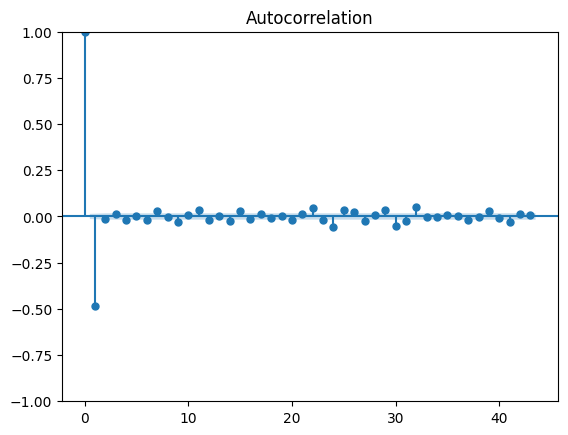

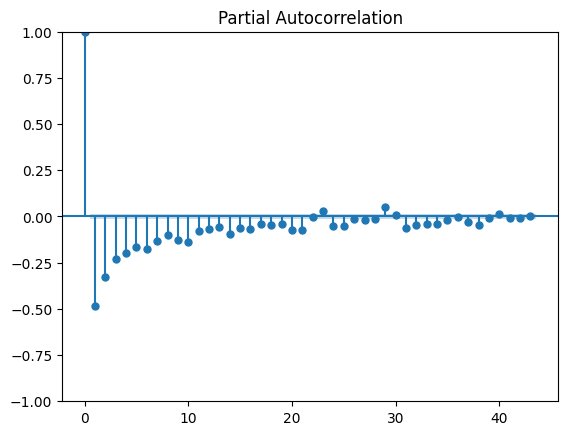

In [5]:
# Check whether your time Series Data is Stationary
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    logging.info(f'ADF Statistic: {result[0]}')
    logging.info(f'p-value: {result[1]}')
    for key, value in result[4].items():
        logging.info(f'Critical Values: {key}, {value}')

check_stationarity(store_sales_train['Sales'])

# Depending on your conclusion from above, difference your time series data
store_sales_train_diff = store_sales_train.diff().dropna()

# Check for autocorrelation and partial autocorrelation of your data
plot_acf(store_sales_train_diff)
plot_pacf(store_sales_train_diff)
plt.show()

Transform the Time Series Data into Supervised Learning Data

In [6]:
# Transform the time series data into supervised learning data
def create_supervised_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 30
X_train, y_train = create_supervised_data(store_sales_train_diff.values, window_size)

Scale the Data

In [7]:
# Scale your data in the (-1, 1) range
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))

Build and Train the LSTM Model

Epoch 1/50
477/477 [==============================] - 19s 33ms/step - loss: 0.0077 - val_loss: 0.0072
Epoch 2/50
477/477 [==============================] - 15s 32ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 3/50
477/477 [==============================] - 13s 28ms/step - loss: 0.0065 - val_loss: 0.0071
Epoch 4/50
477/477 [==============================] - 14s 30ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 5/50
477/477 [==============================] - 15s 31ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 6/50
477/477 [==============================] - 16s 34ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 7/50
477/477 [==============================] - 14s 30ms/step - loss: 0.0064 - val_loss: 0.0070
Epoch 8/50
477/477 [==============================] - 14s 30ms/step - loss: 0.0064 - val_loss: 0.0072
Epoch 9/50
477/477 [==============================] - 14s 30ms/step - loss: 0.0064 - val_loss: 0.0071
Epoch 10/50
477/477 [==============================] - 14s 29ms/step - loss: 0.006

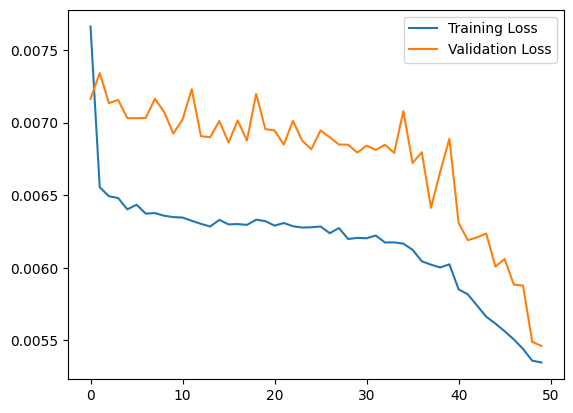

In [8]:
# Build an LSTM Regression model to predict the next sale
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Make Predictions and Evaluate the Model

120/120 [==============================] - 1s 11ms/step


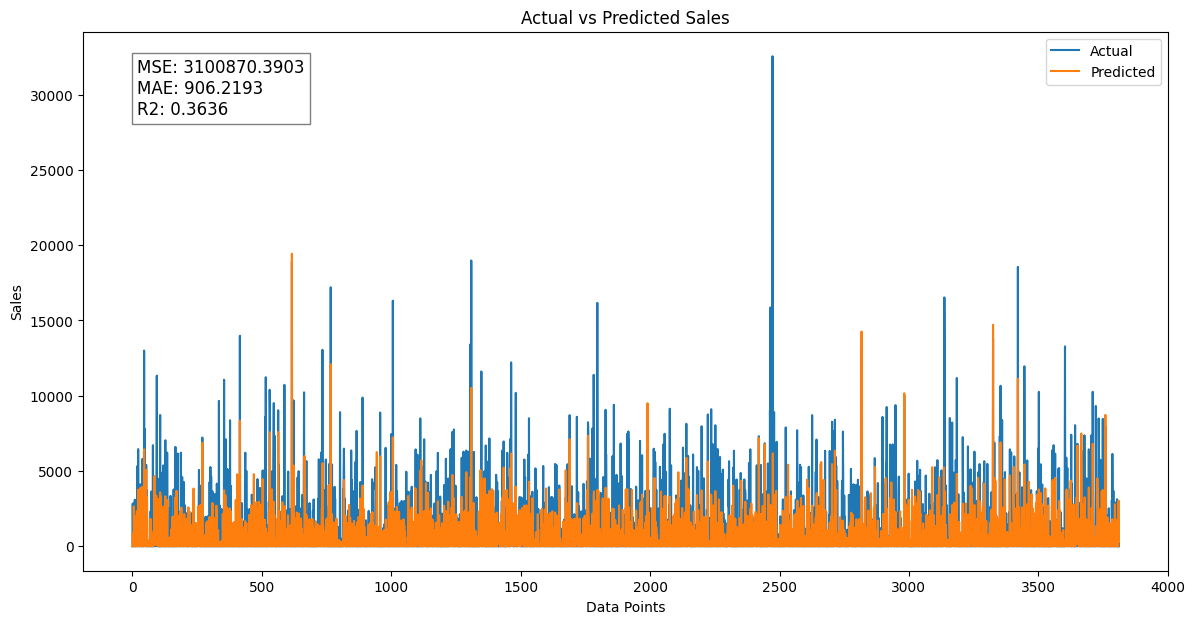

In [12]:
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_split)

# Inverse transform the predictions and actual values
y_val_pred_inv = scaler.inverse_transform(y_val_pred)
y_val_split_inv = scaler.inverse_transform(y_val_split)

# Ensure forecasted values are non-negative
y_val_pred_inv[y_val_pred_inv < 0] = 0
y_val_split_inv[y_val_split_inv < 0] = 0

# Calculate evaluation metrics
mse = mean_squared_error(y_val_split_inv, y_val_pred_inv)
mae = mean_absolute_error(y_val_split_inv, y_val_pred_inv)
r2 = r2_score(y_val_split_inv, y_val_pred_inv)

logging.info(f'Mean Squared Error: {mse}')
logging.info(f'Mean Absolute Error: {mae}')
logging.info(f'R-squared: {r2}')

# Plot actual vs predicted values with evaluation metrics
plt.figure(figsize=(14, 7))
plt.plot(y_val_split_inv, label='Actual')
plt.plot(y_val_pred_inv, label='Predicted')
plt.xlabel('Data Points')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales')
plt.legend()
plt.text(0.05, 0.95, f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nR2: {r2:.4f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

Generate Forecasts for the Next Six Weeks

1/1 [==============================] - 0s 27ms/step


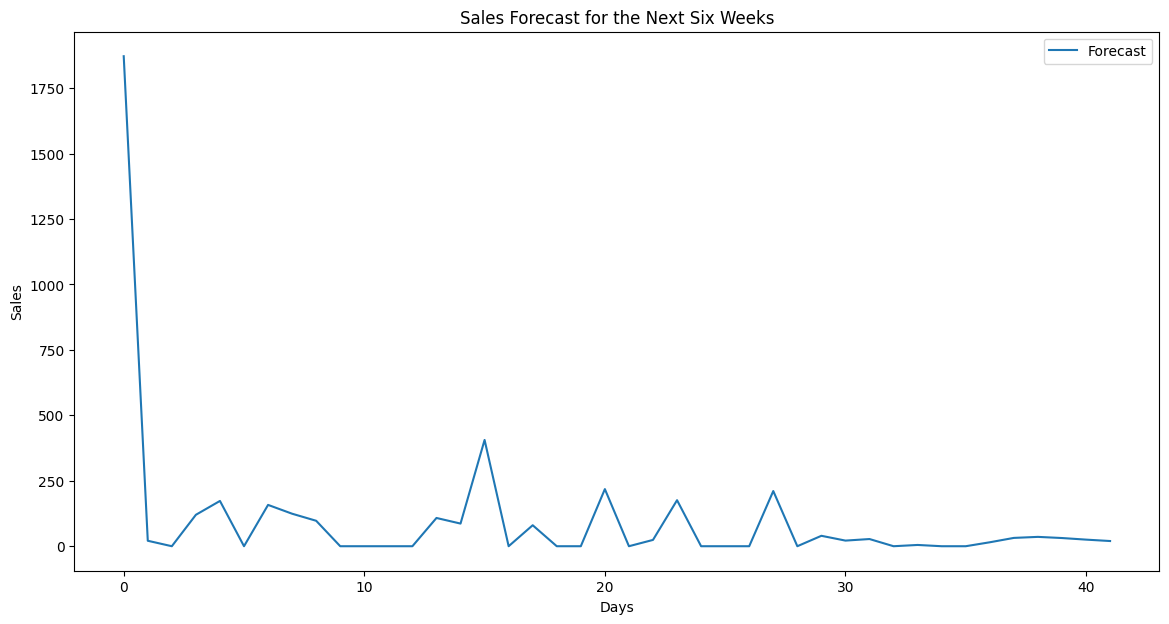

In [10]:
def multi_step_forecast(model, data, window_size, steps):
    forecast = []
    input_seq = data[-window_size:]
    for _ in range(steps):
        input_tensor = np.expand_dims(input_seq, axis=0)
        pred = model.predict(input_tensor)
        forecast.append(pred[0])
        input_seq = np.append(input_seq[1:], pred[0])
        input_seq = input_seq.reshape(-1, 1)  # Ensure the input sequence has the correct shape
    return np.array(forecast)
# Generate forecasts for the next six weeks (42 days)
steps = 42
forecast = multi_step_forecast(model, X_train_scaled[-1], window_size, steps)

# Inverse transform the forecasted values
forecast_inv = scaler.inverse_transform(forecast)

# Ensure forecasted values are non-negative
forecast_inv[forecast_inv < 0] = 0

# Plot the forecasted values
plt.figure(figsize=(14, 7))
plt.plot(range(steps), forecast_inv, label='Forecast')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.title('Sales Forecast for the Next Six Weeks')
plt.legend()
plt.show()